In [1]:
import os
import pandas as pd

In [2]:
fns = os.listdir('../processed_data/adj_expression/')

In [3]:
with open('../processed_data/model_genes.txt', 'rb') as reader:
    selected_genes = set([s.strip() for s in reader.readlines()])

In [4]:
f = fns[0]
tissue = f.split('-')[0]
df_exp = pd.read_csv('../processed_data/adj_expression/' + f, index_col=0, nrows = 5)    
id2gene = [str(s) for s in df_exp.columns if s.split('.')[0] in selected_genes]
assert(len(id2gene) == len(selected_genes))

In [5]:
len(id2gene)

11890

In [6]:
data = []
id2tissue = []
for i, f in enumerate(fns):
    tissue = f.split('-')[0]
    df_exp = pd.read_csv('../processed_data/adj_expression/' + f, index_col=0)
    df_exp = df_exp[id2gene]
    data.append(df_exp.values)
    id2tissue += [tissue] * df_exp.shape[0]

In [7]:
len(id2tissue)

7051

In [8]:
import numpy as np
data = np.vstack(data)

In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import tensorflow as tf


In [10]:
def DNN(x, theta_mat, is_train, scope = 'linear', reuse = tf.AUTO_REUSE):
    h_in = x 
    with tf.variable_scope(scope, reuse=reuse):
        for i, n_node in enumerate(theta_mat):
            h_out = tf.layers.dense(h_in, n_node, name = 'h%02d/dense' % i, use_bias=False)
            h_in = h_out
            #
            if (i > 0) and ((i+1) != len(theta_mat)):
                h_in = tf.layers.batch_normalization(h_in, training=is_train, name = 'h%02d/batch_norm' % i)
                #h_in = tf.layers.dropout(h_in, rate=0.5, training=is_train)
            #h_in = tf.nn.relu(h_in) 
            h_in = tf.nn.tanh(h_in)   
    return h_out

In [11]:
num_gene = len(id2gene)

In [12]:
data.shape

(7051, 11890)

In [13]:
num_sample = data.shape[0]

ind_train = np.array([i for i in range(num_sample) if i % 20 != 0])
ind_test = np.array([i for i in range(num_sample) if i % 20 == 0])

train_data = data[ind_train, :].astype('float32')
test_data = data[ind_test, :].astype('float32')

num_sample = train_data.shape[0]

In [14]:
from sklearn.decomposition import PCA
clf = PCA(n_components = 512, whiten=False)
clf.fit(train_data)

PCA(copy=True, iterated_power='auto', n_components=512, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [15]:
V0 = clf.components_ / np.linalg.norm(clf.components_.T)
U0 = clf.components_.T * np.linalg.norm(clf.components_.T) 
V0 = V0.astype('float32')
U0 = U0.astype('float32')

In [16]:
#norm0 = np.linalg.norm(V0)

In [16]:
beta1 = 0.9

with tf.device("/gpu:0"):
    tf.reset_default_graph()
    
    ##========================= define inputs ===========================##
    is_training = tf.placeholder(tf.bool, name = 'is_training')
    l1_penalty = tf.placeholder(tf.float32, name = 'l1_penalty')
    
    inputs = tf.placeholder(tf.float32, [None, num_gene], 
                            name='inputs')
    
    ## net for inference
    theta_mat = [512, 1024, num_gene]
    
    l1_scaled = l1_penalty * (0.5 * float(num_sample) / float(theta_mat[0]) ) 
    
    w0_tf = tf.get_variable('w0_tf', initializer=U0)
    w1_tf = tf.get_variable('w1_tf', initializer=V0)
    
    #w1n_tf = w1_tf / tf.stop_gradient(tf.linalg.norm(w1_tf))
    w1n_tf = w1_tf / tf.linalg.norm(w1_tf) 
    
        
    h0 = tf.matmul(inputs, w0_tf, name = 'h0')
    logit_rec = tf.matmul(h0, w1n_tf, name = 'h1')
    
    rec_loss_l2 = tf.reduce_mean(tf.square(logit_rec - inputs))
    
    ## net for training, data loaded on GPU to save computation
    inputs_train0 = tf.constant(train_data, name = 'input_training')
    inputs_train = inputs_train0 + tf.random.normal(tf.shape(inputs_train0), mean=0.0, stddev=.1)
    
    h0_train = tf.matmul(inputs_train, w0_tf, name = 'h0_train')
    logit_rec_train = tf.matmul(h0_train, w1n_tf, name = 'h1_train')
    
    rec_loss_l2_train = tf.reduce_mean(tf.square(logit_rec_train - inputs_train0))
    
    d_loss = rec_loss_l2_train + l1_scaled * tf.reduce_mean(tf.abs(w0_tf))
    
    
    d_lrd = tf.placeholder(tf.float32, name = 'd_lrd')
    
    d_optim = tf.train.AdamOptimizer(d_lrd, beta1=beta1)  
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_train_op = d_optim.minimize(d_loss)


In [17]:
sess = tf.Session()

In [22]:
sess.run(tf.global_variables_initializer())

In [28]:
res = []
#for l1_val in [0.1, 0.2, 0.5, 0.7, 1.0, 1.2, 1.5, 1.7, 2.0, 2.2, 2.5]:
for l1_val in [2.0]:
#for l1_val in [2.2, 2.5]:
    print l1_val
    errD0, errD1, D_count = 0.0, 0.0, 0.0
    for idx in range(2000):
        lrd = 1e-2 / np.sqrt(idx * 0.005 + 1.0)

        feed_dict={is_training:True, l1_penalty: l1_val, d_lrd: lrd}

        val0, val1, _ = sess.run([d_loss, rec_loss_l2_train, d_train_op], feed_dict=feed_dict)
        
        errD0 += val0
        errD1 += val1
        D_count += 1.0

        if idx % 100 == 0:
            errD0 = errD0 / D_count
            errD1 = errD1 / D_count
            
            feed_dict={inputs: test_data, is_training:False,}            

            test_errD1 = sess.run(rec_loss_l2, feed_dict=feed_dict)

            msr = "iter: %4d, full_loss: %.4f, train_loss: %.4f, test_loss: %.4f" \
                % (idx, errD0, errD1, test_errD1)
            print(msr)
            errD0, errD1, D_count = 0.0, 0.0, 0.0


    feed_dict={inputs: test_data, is_training:False}            
    test_err = sess.run(rec_loss_l2, feed_dict=feed_dict)

    feed_dict={inputs: train_data, is_training:False,}            
    train_err = sess.run(rec_loss_l2, feed_dict=feed_dict)

    w0_val = sess.run(w0_tf)
    tmp = []
    for i in range(512):
        thre = max((0.001 * np.abs(w0_val[:, i])).max(), 1e-5)
        tmp.append(np.sum(np.abs(w0_val[:, i]) > thre ))
    res.append([l1_val, tmp, train_err, test_err, w0_val])


2.0
iter:    0, full_loss: 1.0719, train_loss: 0.5122, test_loss: 0.6238
iter:  100, full_loss: 0.8204, train_loss: 0.6424, test_loss: 0.7037
iter:  200, full_loss: 0.7558, train_loss: 0.6381, test_loss: 0.7010
iter:  300, full_loss: 0.7417, train_loss: 0.6324, test_loss: 0.7006
iter:  400, full_loss: 0.7340, train_loss: 0.6298, test_loss: 0.7008
iter:  500, full_loss: 0.7289, train_loss: 0.6283, test_loss: 0.7010
iter:  600, full_loss: 0.7252, train_loss: 0.6274, test_loss: 0.7013
iter:  700, full_loss: 0.7223, train_loss: 0.6267, test_loss: 0.7015
iter:  800, full_loss: 0.7199, train_loss: 0.6262, test_loss: 0.7018
iter:  900, full_loss: 0.7178, train_loss: 0.6258, test_loss: 0.7020
iter: 1000, full_loss: 0.7161, train_loss: 0.6255, test_loss: 0.7022
iter: 1100, full_loss: 0.7145, train_loss: 0.6252, test_loss: 0.7023
iter: 1200, full_loss: 0.7131, train_loss: 0.6250, test_loss: 0.7025
iter: 1300, full_loss: 0.7118, train_loss: 0.6247, test_loss: 0.7025
iter: 1400, full_loss: 0.7107,

In [27]:
for item in res:
    print -item[3] * num_gene * 0.5 - (np.log(test_data.shape[0]) / test_data.shape[0]) * np.sum(item[1])

-19956.252807551267
-10727.02287225406
-5489.476143895949
-4854.9223329553015
-4553.027703844936
-4481.637149930246
-4433.556597285045
-4414.926850199992
-4408.7004049421
-4412.166162251571
-4419.859754100702


In [28]:
test_data.shape

(353, 11890)

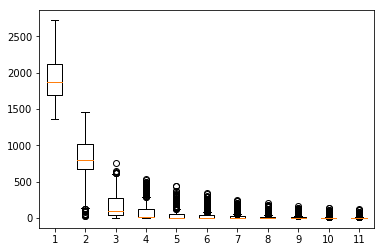

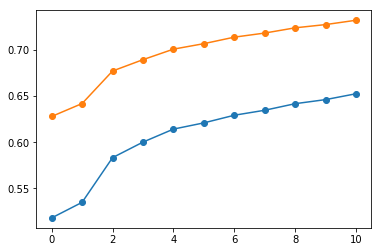

In [29]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.boxplot([item[1] for item in res])
plt.show()

plt.plot([item[2] for item in res], '-o')
plt.plot([item[3] for item in res], '-o')
plt.show()

In [30]:
w0_val = res[8][-1]

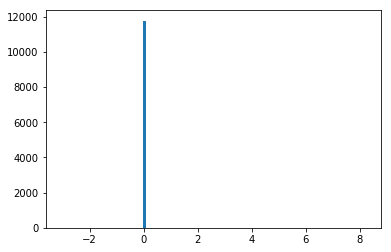

In [29]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.hist(w0_val[:, 1], bins = 100)
plt.show()

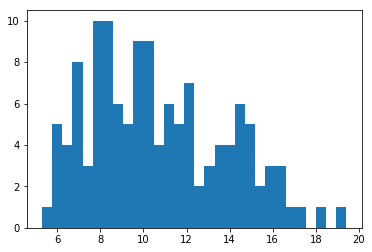

In [30]:
plt.hist([np.max(np.abs(w0_val[:, i])) for i in range(128)], bins = 30)
plt.show()

In [33]:
np.abs(w0_val[:, 0]).max()

15.6696205

In [34]:
from statsmodels import robust

In [36]:
for i in range(100):
    thre = max((0.001 * np.abs(w0_val[:, i])).max(), 1e-5)
    #thre = 3.0 * w0_val[:, i].std()
    #thre = 1.8 * robust.mad(w0_val[:, i])
    #thre = 1e-5
    print i, np.sum(np.abs(w0_val[:, i]) > thre ), thre, np.sum(np.abs(w0_val[:, i]) > 100. * thre ), np.max(np.abs(w0_val[:, i]))

0 71 0.015669622 31 15.6696205
1 24 0.01375312 18 13.753119
2 89 0.008184988 53 8.184988
3 68 0.00776106 45 7.7610593
4 142 0.0066343807 82 6.6343803
5 9 0.027802166 7 27.802164
6 38 0.01034461 24 10.344609
7 66 0.017844994 26 17.844994
8 45 0.011822513 33 11.822513
9 28 0.021414034 16 21.414034
10 79 0.00807061 53 8.07061
11 75 0.009606389 41 9.606389
12 60 0.012111392 35 12.111391
13 112 0.011588343 49 11.588343
14 38 0.0077302787 29 7.7302785
15 92 0.0063475273 61 6.347527
16 76 0.015099348 33 15.099347
17 25 0.0146676665 19 14.6676655
18 18 0.031531233 8 31.531233
19 63 0.008513132 44 8.513132
20 166 0.0072569177 82 7.2569175
21 88 0.008184202 50 8.184201
22 76 0.009303907 42 9.303906
23 79 0.0075815544 50 7.581554
24 41 0.015446025 19 15.446024
25 49 0.013513 26 13.513
26 76 0.007683311 46 7.683311
27 123 0.0073244837 60 7.3244834
28 25 0.01350033 17 13.500329
29 3 0.03923385 3 39.233845
30 115 0.008784139 60 8.784138
31 137 0.008106545 69 8.1065445
32 39 0.026737275 13 26.737274


In [37]:
gene_mat = np.zeros(w0_val.shape)

for i in range(512):
    thre = (0.001 * np.abs(w0_val[:, i])).max()
    gene_mat[:, i] = np.abs(w0_val[:, i]) > thre

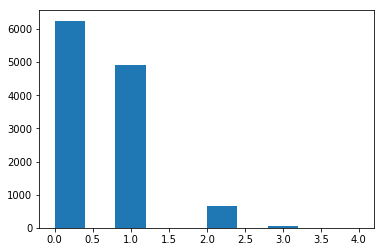

In [38]:
plt.hist(gene_mat.sum(axis = 1))
plt.show()

/data1/users/hclee/hclee/python2/local/lib/python2.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


KeyboardInterrupt: 

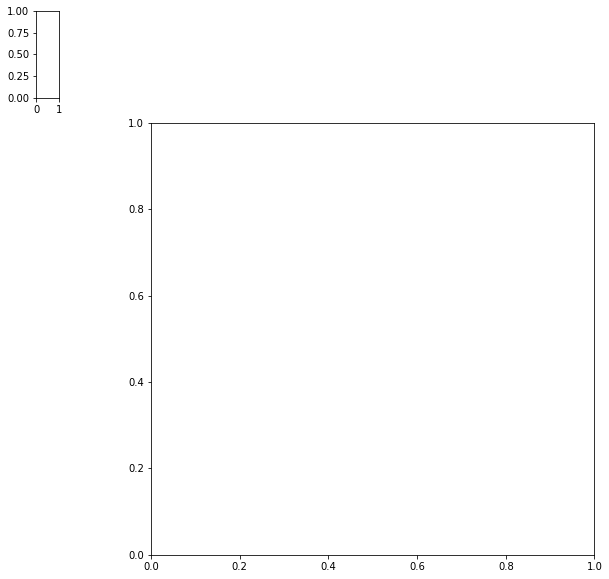

In [39]:
import seaborn.apionly as sns

sns.clustermap(w0_val, cmap = 'RdBu_r')
plt.show()

In [ ]:
sns.clustermap(test_data.dot(w0_val), cmap = 'RdBu_r')
plt.show()

In [84]:
import pickle
with open('ensembl2genename.p', 'rb') as reader:
    gid2gn = pickle.load(reader)

In [113]:
i = 32
thre = (0.001 * np.abs(w0_val[:, i])).max()

for i in np.where(np.abs(w0_val[:, i]) > thre)[0]:
    gid = id2gene[i].split('.')[0]
    if gid in gid2gn:
        print gid2gn[gid]
    else:
        print gid

NOL9
DFFA
EMC1
GPN2
GMEB1
INPP5B
TAF13
CAPZA1
LRIG2
GABPB2
GATAD2B
TOR1AIP2
MDM4
BPNT1
SLC25A16
ZBTB3
CEP295
CCDC84
CSAD
MDM2
PGAM5
GOLGA3
ZBTB25
FAM134C
NFIC
ZNF557
ZNF121
ZNF562
ZNF791
SLC35E1
ZNF101
IRGQ
ZNF587
C2orf68
UGGT1
CNOT9
PEX26
XPNPEP3
VHL
RBSN
RAD54L2
RNF168
LRCH3
LETM1
DCAF16
ABHD18
NUP155
NUP43
FOXK1
TMED4
CRCP
HOOK3
SMU1
GAPVD1
EXOSC2


In [62]:
feed_dict={inputs: test_data, 
           is_training:False,
           l1_penalty: l1_val,
           #noise_level: 0.05, 
           d_lrd: lrd,
            }

rec_val = sess.run(logit_rec, feed_dict=feed_dict)

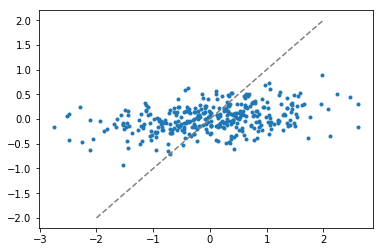

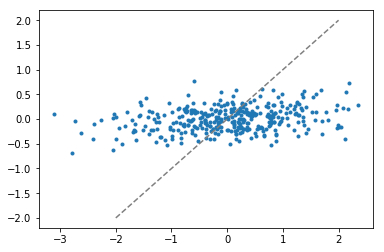

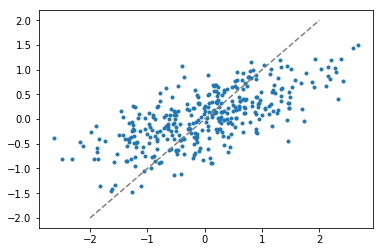

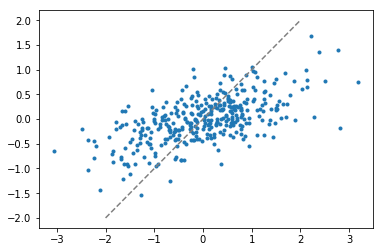

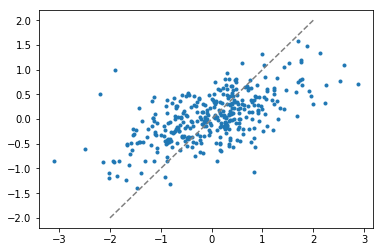

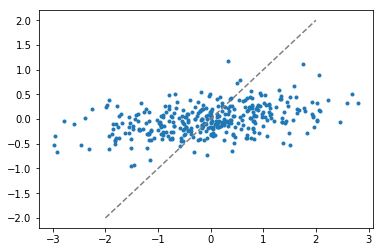

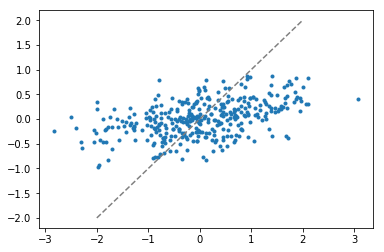

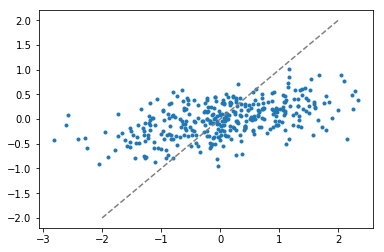

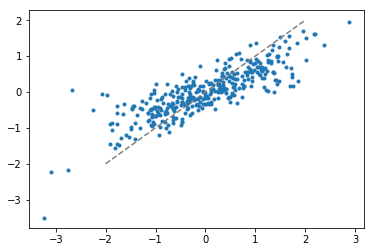

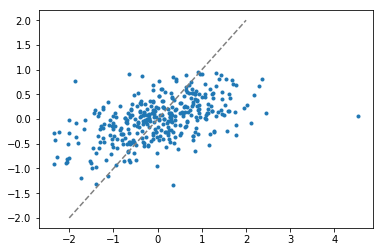

In [63]:
for i in range(0, 100, 10):
    plt.plot(test_data[:, i], rec_val[:, i], '.')
    plt.plot([-2.0, 2.0], [-2.0, 2.0], '--', color = 'gray')
    plt.show()

In [18]:
from sklearn.decomposition import PCA
clf = PCA(n_components = 512)
clf.fit(train_data)

In [19]:
clf.fit(train_data)

PCA(copy=True, iterated_power='auto', n_components=512, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [20]:
clf.explained_variance_ratio_.sum()

0.48809826

In [21]:
test_rec = clf.inverse_transform(clf.transform(test_data))

In [22]:
np.mean((test_rec - test_data) ** 2)

0.6111599

In [23]:
train_rec = clf.inverse_transform(clf.transform(train_data))
np.mean((train_rec - train_data) ** 2)

0.5089995